In [1]:
import numpy as np
#import pandas as pd

import mlgrad.model as model
import mlgrad.func as func
import mlgrad.dissimilarity as dissimilarity
import mlgrad.regular as regular
import mlgrad.avragg as avragg
import mlgrad.averager as averager
import mlgrad.gd as gd
import mlgrad.loss as loss
import mlgrad.pbfg as pbfg
#import mlgrad.pbsag as pbsag

#import sklearn.linear_model as linear_model
#import sklearn.datasets as datasets
#import sklearn.metrics as metrics
#import sklearn.decomposition as decomposition

import matplotlib.pyplot as plt
plt.matplotlib.rcParams['figure.dpi']=120
plt.matplotlib.rcParams['savefig.dpi']=120

#%matplotlib inline
#%config BackendInline.format='svg'

## Искусственный пример

In [2]:
def gendataset(N=100, m=3, dy=2.):
    X0 = np.linspace(-8., 8., N)
    Y0 = 3. * X0
    Y0 += 2 * dy * np.random.random((N,)) - dy

    XY = 2. * np.random.random((m*N, 2))-1.
    X1 = XY[:, 0]
    Y1 = XY[:, 1]
    Y1 = 24. * np.sign(Y1) * np.abs(Y1) ** 0.66
    X1 *= 10

    X = np.hstack((X0, X1))
    X = X.reshape((-1,1))
    Y = np.hstack((Y0, Y1))
    return X, Y

In [3]:
m = 5
dy = 0
X, Y = gendataset(m=m, dy=dy)

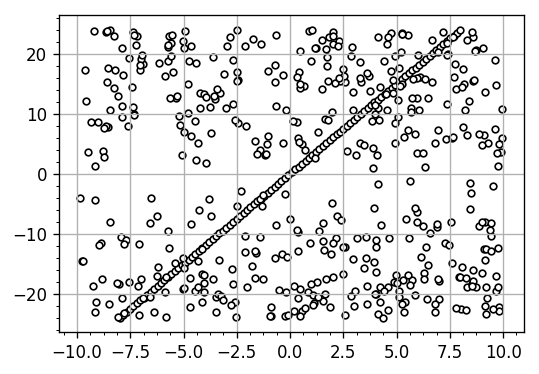

In [4]:
plt.figure(figsize=(5, 3.5))
plt.scatter(X, Y, s=16, marker='o', c='w', edgecolors='k', linewidths=1.)
plt.grid(1)
plt.minorticks_on()
plt.show()

In [5]:
loss_func = loss.ErrorLoss(func.Square())
loss_func

In [6]:
param_init_square = np.random.random((2,))
lm_line_square = model.LinearModel(param_init_square)

alg_square = gd.erm_fg(X, Y, lm_line_square, loss_func, h=5.5)
print(alg_square.K, lm_line_square.param.base)

128 [-0.22648942  0.21079065]
128 [-0.22648942  0.21079065]


In [7]:
param_init_sqrt = np.random.random((2,))
lm_line_sqrt = model.LinearModel(param_init_sqrt)

loss_func_sqrt = loss.ErrorLoss(func.Sqrt())

alg_sqrt = gd.erm_fg(X, Y, lm_line_sqrt, loss_func_sqrt)
print(alg_sqrt.K, lm_line_sqrt.param.base)

25 [ 0.65032753  0.64957367]
25 [ 0.65032753  0.64957367]


In [8]:
param_init_q = np.random.random((2,))
lm_line_q = model.LinearModel(param_init_q)

loss_func_q = loss.ErrorLoss(func.Quantile(0.5))

alg_q = gd.erm_fg(X, Y, lm_line_q, loss_func_q)
print(alg_q.K, lm_line_q.param.base)

67 [ 0.93791237  0.63865008]
67 [ 0.93791237  0.63865008]


In [9]:
param_init_e = np.random.random((2,))
lm_line_e = model.LinearModel(param_init_e)

loss_func_e = loss.ErrorLoss(func.Expectile(0.3))

alg_e = gd.erm_fg(X, Y, lm_line_e, loss_func_e)
print(alg_e.K, lm_line_e.param.base)

883 [ 5.42364503  0.16844476]
883 [ 5.42364503  0.16844476]


In [27]:
#param_init2 = np.random.random((2,))
param_init2 = np.array([0.,-1.])
lm_line2 = model.LinearModel(param_init2)

penalty_func = func.Quantile_AlphaLog(0.01, 0.17)
#penalty_func = func.Sqrt()
loss_func = loss.ErrorLoss(func.Square())
#loss_func = loss.ErrorLoss(func.Sqrt())

d = {"u":[],"param":[], "K":[], "Ka":[], 'lval_min':[]}
def callback(alg, d=d):
    d["u"].append(alg.average.u)
    d["K"].append(alg.gd.K)
    d["Ka"].append(alg.average.K)
    d["lval_min"].append(alg.gd.lval_min)
    d["param"].append(lm_line2.param.base.copy())
    
alg_pbfg = pbfg.erm_pbfg(X, Y, lm_line2, loss_func, penalty_func, callback, h_gd=0.001, h_avr=0.01, tol=1.0e-4)

print(alg_pbfg.average.K, alg_pbfg.gd.K, alg_pbfg.K, alg_pbfg.average.u, lm_line2.param.base)

16 [-0.07750421  2.980176  ]
1000 3802 16 10.756454981572434 [-0.07750421  2.980176  ]


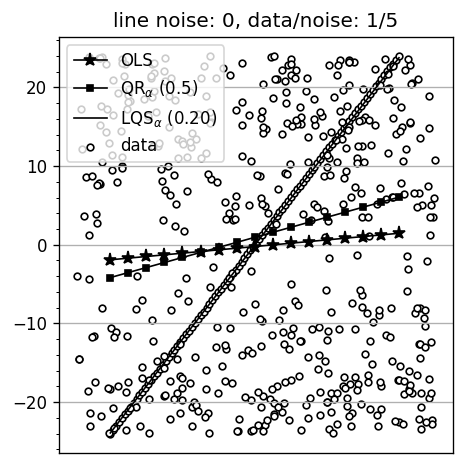

In [28]:
plt.figure(figsize=(4, 4))
plt.title('line noise: %s, data/noise: 1/%s' % (dy, m))
plt.scatter(X, Y, s=16, marker='o', c='w', edgecolors='k', linewidths=1., label='data')
plt.grid(1)
plt.minorticks_on()
xrange = np.linspace(-8., 8., 17)
plt.plot(xrange, lm_line_square.evaluate_all(xrange), color='k', linewidth=1., marker='*', markersize=8, label=r'OLS')
#plt.plot(xrange, lm_line_sqrt.evaluate_all(xrange), color='k', linewidth=1., marker='v', markersize=8, label=r'Sqrt')
plt.plot(xrange, lm_line_q.evaluate_all(xrange), color='k', linewidth=1., marker='s', markersize=4, label=r'QR$_\alpha$ (0.5)')
#plt.plot(xrange, lm_line_e.evaluate_all(xrange), color='k', linewidth=1., marker='v', markersize=4, label=r'ER/0.25')
#plt.plot(xrange, lm_line_huber.evaluate_all(xrange), color='k', linewidth=1., marker='v', markersize=8, label='huber')
plt.plot(xrange, lm_line2.evaluate_all(xrange), color='k', linewidth=1., label=r'LQS$_\alpha$ (0.20)')
#plt.plot(xrange, lm_line3.evaluate_all(xrange), color='k', linewidth=1., marker='+', label=r'LQSag$_\alpha$ (0.35)')
plt.legend(loc='upper left')
plt.xticks([],[])
#plt.yticks([],[])
plt.tight_layout()
plt.savefig('fig/rob_regr_2_2.png')
plt.show()

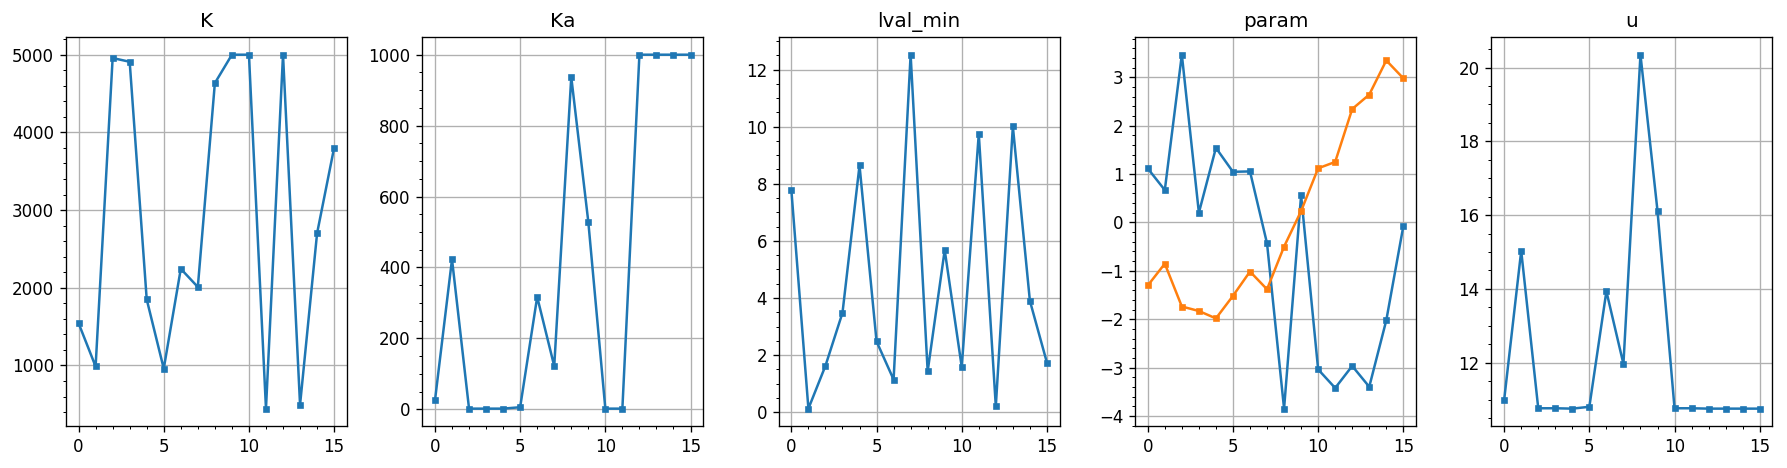

In [29]:
def plot_log(d):
    plt.figure(figsize=(15,4))
    m = len(d)
    i = 1
    for key, vals in sorted(d.items()):
        plt.subplot(1, m, i)
        k_range, u_seq = zip(*enumerate(d[key]))
        plt.plot(k_range, u_seq, marker='s', markersize=3)
        plt.grid(1)
        plt.title(key)
        plt.minorticks_on()
        i += 1
        plt.tight_layout()
    plt.show()
    
plot_log(d)

In [13]:
# param_init3 = np.array([0.,-1.])
# lm_line3 = model.LinearModel(param_init3)

# penalty_func2 = func.Quantile_AlphaLog(0.01, 0.18)
# #loss_func = loss.Loss(func.Square())
# #penalty_func = func.Power(1.1)

# d2 = {"u":[],"param":[]}
# def callback2(alg):
#     d2["u"].append(alg_pbsag.u)
#     d2["param"].append(lm_line3.param.base.copy())

# alg_pbsag = pbsag.PbSAG(lm_line3, loss_func, penalty_func2, hw=0.001, hu=0.01, tol=1.0e-6, n_iter=10000)
# alg_pbsag.callback = callback2
# alg_pbsag.fit(X,Y)
# print(alg_pbsag.K, lm_line3.param.base)

In [14]:
#plot_log(d2)